In [27]:
import os
import glob
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import torch
from torch.nn.functional import grid_sample
from affine_transformations_support_functions import *

In [28]:
# load affine calibration
A = torch.load('20241104_1360x1360_to_DMD.pt', weights_only=True)
print(A)

tensor([[-1.6718e-02,  1.1725e+00, -1.9525e+02],
        [-5.9400e-01, -1.5005e-02,  9.1334e+02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)


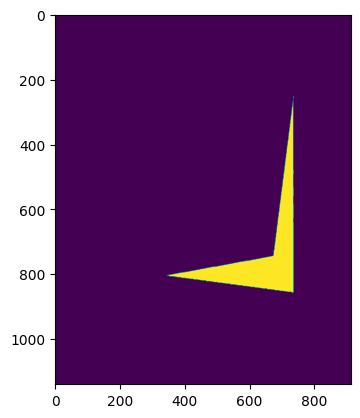

In [29]:
# load target .bmp example
tri_1_bmp = plt.imread('../03_patterns/20240913_DMD_patterns_export/20240919-Calibration/triangle_1.bmp')
tri_1_bmp_norm = normalize(tri_1_bmp)
plt.imshow(tri_1_bmp_norm)

### Folder Pipeline

Processing images:   0%|          | 0/717 [00:00<?, ?it/s]

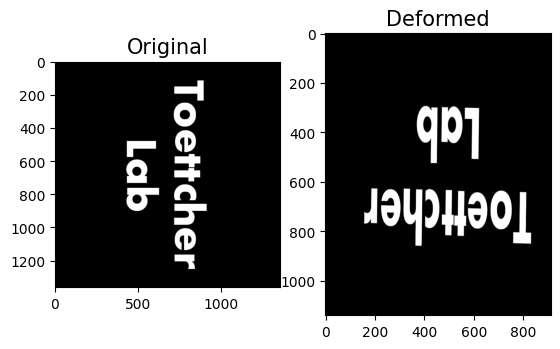

Processing images:   7%|▋         | 50/717 [00:10<02:12,  5.03it/s]

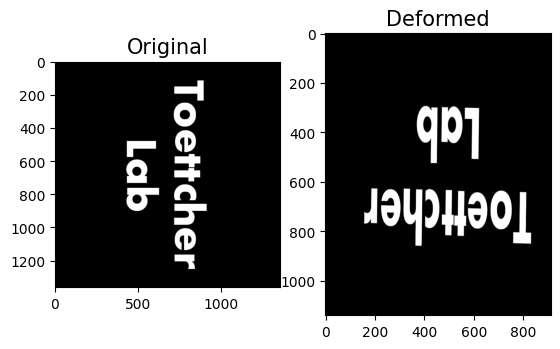

Processing images:  10%|█         | 74/717 [00:15<02:07,  5.06it/s]t:\Jerry\01_projects\EJW001_Communicating-With-Polygon\04_affine\affine_transformations_support_functions.py:289: RuntimeWarning: invalid value encountered in divide
  norm_arr = ((arr - min_)/diff_arr * diff) + t_min
C:\Users\Jerro\AppData\Local\Temp\ipykernel_32928\3529153225.py:9: RuntimeWarning: invalid value encountered in cast
  array = tensor.numpy().astype(np.uint8)
Processing images:  14%|█▍        | 100/717 [00:20<02:02,  5.04it/s]

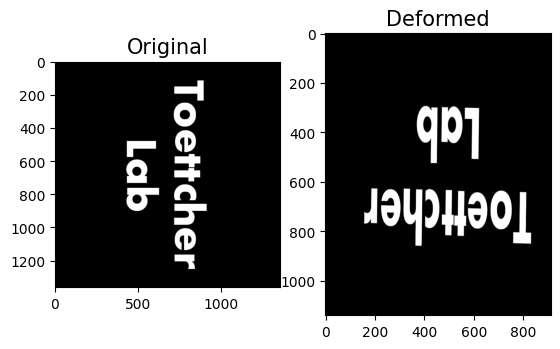

Processing images:  21%|██        | 150/717 [00:30<02:05,  4.52it/s]

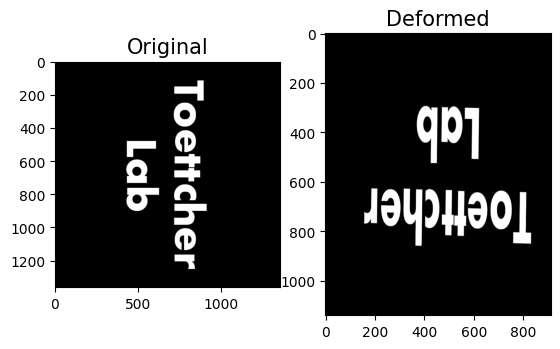

Processing images:  28%|██▊       | 200/717 [00:41<01:48,  4.77it/s]

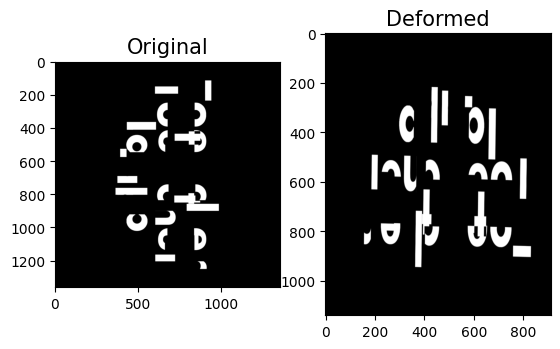

Processing images:  35%|███▍      | 250/717 [00:51<01:41,  4.59it/s]

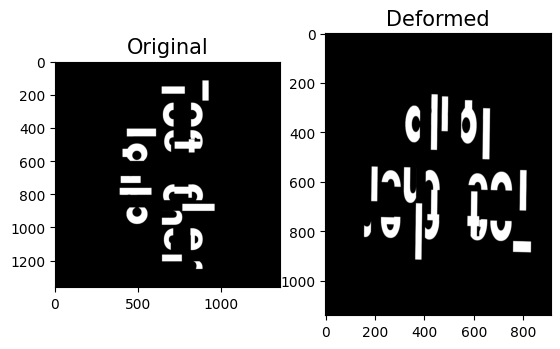

Processing images:  42%|████▏     | 300/717 [01:01<01:15,  5.51it/s]

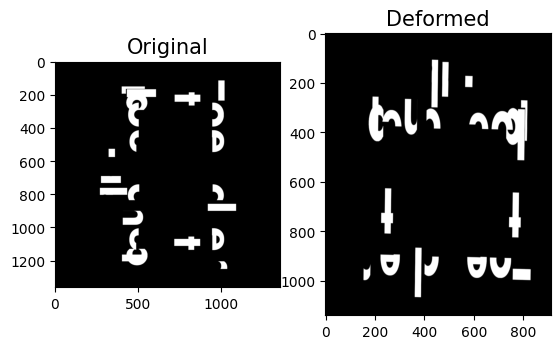

Processing images:  49%|████▉     | 350/717 [01:11<01:13,  5.02it/s]

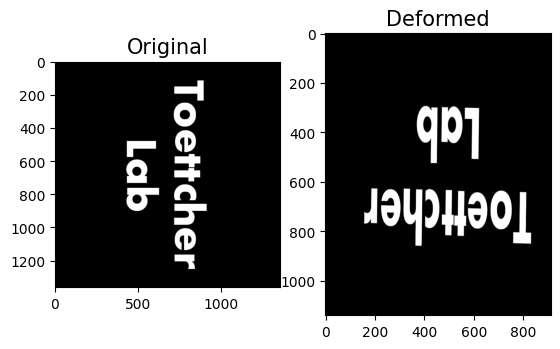

Processing images:  56%|█████▌    | 400/717 [01:21<01:08,  4.64it/s]

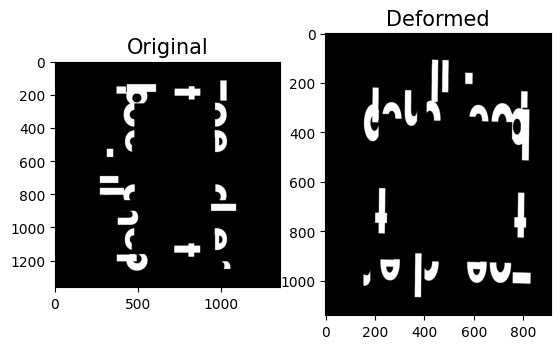

Processing images:  63%|██████▎   | 450/717 [01:33<01:04,  4.15it/s]

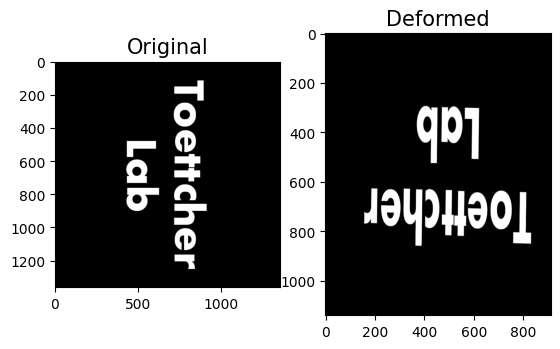

Processing images:  70%|██████▉   | 500/717 [01:43<00:42,  5.08it/s]

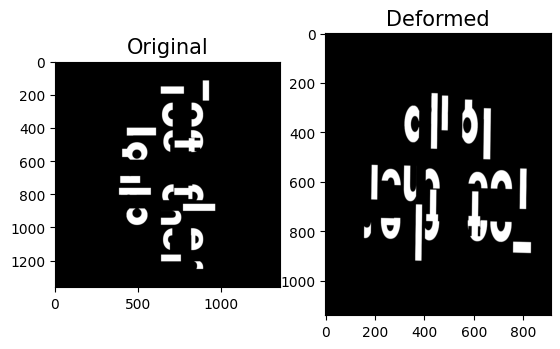

Processing images:  77%|███████▋  | 550/717 [01:53<00:34,  4.83it/s]

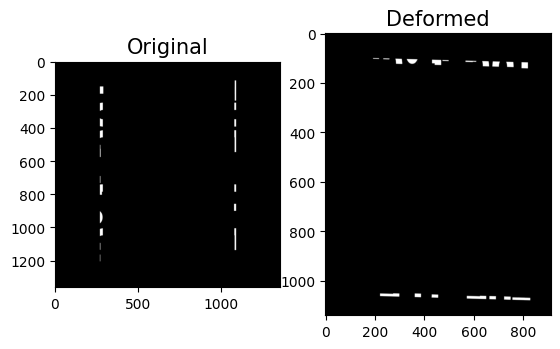

Processing images:  84%|████████▎ | 600/717 [02:05<00:24,  4.70it/s]

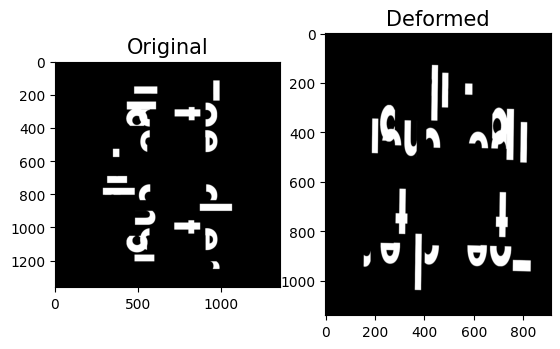

Processing images:  91%|█████████ | 650/717 [02:15<00:12,  5.16it/s]

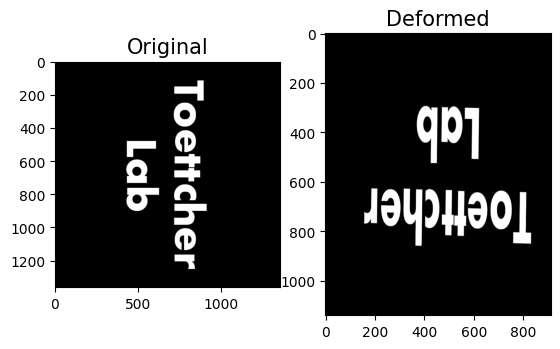

Processing images:  98%|█████████▊| 700/717 [02:26<00:03,  4.39it/s]

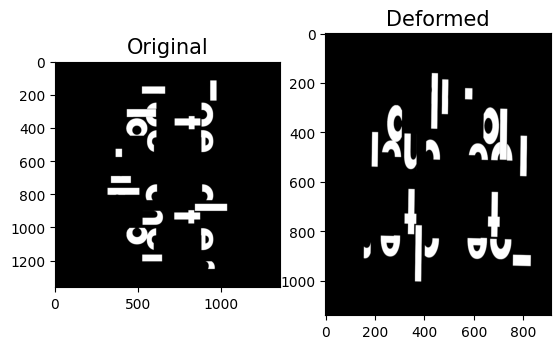

Processing images: 100%|██████████| 717/717 [02:30<00:00,  4.77it/s]


In [ ]:
def save_tensor_as_bmp(tensor, file_path):
    """
    Converts a single-channel torch tensor with values in the range [0, 1] to an 8-bit .bmp file.
    """
    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)  # Remove the singleton dimension

    tensor = tensor * 255.0
    array = tensor.numpy().astype(np.uint8)
    image = Image.fromarray(array)
    image.save(file_path, format='BMP')

# Define the processing function
def process_image(image_path, output_folder, index):
    # Read, process, and transform each image
    img = plt.imread(image_path)
    img = rgb_to_grayscale(img)
    img_norm = normalize(img)

    # Prepare I and J (assuming tri_1_bmp_norm is predefined or a placeholder)
    I = np.expand_dims(img_norm, axis=0)
    J = np.expand_dims(tri_1_bmp_norm, axis=0)
    
    YI = np.array(range(I.shape[1])) * 1.
    XI = np.array(range(I.shape[2])) * 1.
    YJ = np.array(range(J.shape[1])) * 1.
    XJ = np.array(range(J.shape[2])) * 1.
    
    extentJ = extent_from_x((YJ, XJ))
    extentI = extent_from_x((YI, XI))
    AI = transform_image_source_with_A(A, [YI, XI], I, [YJ, XJ])

    # Save the transformed image as .bmp in the output folder
    base_name = os.path.splitext(os.path.basename(image_path))[0]  # Extract original name without extension
    save_path = os.path.join(output_folder, f"{base_name}.bmp")
    save_tensor_as_bmp(AI.cpu(), save_path)

    # Plot every 50th image
    if index % 50 == 0:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(I.transpose(1, 2, 0), cmap='gray', extent=extentI)
        ax[1].imshow(AI.permute(1, 2, 0).squeeze(), cmap='gray', extent=extentJ)
        ax[0].set_title('Original', fontsize=15)
        ax[1].set_title('Deformed', fontsize=15)
        plt.show()

# Set the folder paths
input_folder = r"T:\Jerry\01_projects\EJW008_Herding_Arrays\02_patterns\words_pre_affine"
output_folder = r"T:\Jerry\01_projects\EJW008_Herding_Arrays\02_patterns\words_post_affine"
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# Get all image files and process each with a progress bar
image_files = glob.glob(os.path.join(input_folder, "*.jpg"))

for index, image_file in enumerate(tqdm(image_files, desc="Processing images")):
    process_image(image_file, output_folder, index)

### Single Image Pipeline

(1360, 1360)


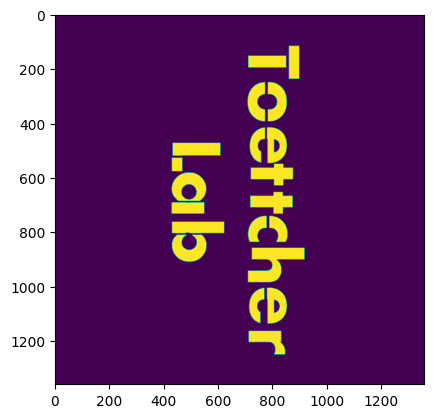

In [19]:
img = plt.imread("Sequence_size_test2.jpg")
img = rgb_to_grayscale(img)
img_norm = normalize(img)
plt.imshow(img_norm)
print(img_norm.shape)


In [20]:
I = np.expand_dims(img_norm, axis=0)
J = np.expand_dims(tri_1_bmp_norm, axis=0)

In [21]:
YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

# get extent of ima


extentJ = extent_from_x((YJ,XJ))
extentI = extent_from_x((YI,XI))

Text(0.5, 1.0, 'Deformed')

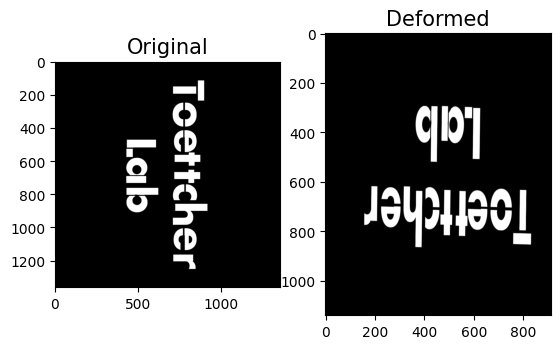

In [22]:
# compute initial affine transformation from points
AI= transform_image_source_with_A(A, [YI,XI], I, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow(I.transpose(1,2,0), cmap='gray', extent=extentI)
ax[1].imshow((AI.permute(1,2,0).squeeze()), cmap='gray', extent=extentJ)

ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Deformed', fontsize=15)